In [18]:
%matplotlib inline

# Version 3 du modèle prédictif

Dans ce notebook, nous allons améliorer le modèle V2 en prenant en compte améliorant l'information sur les buts marqués 

On commence par importer les données dont on aura besoin (le tout est rassemblé en une seule cellule cette fois-ci) :

In [11]:
import pandas as pd
import numpy as np
match = pd.read_csv('data\\match_enhanced.csv', index_col=0, parse_dates=[3], infer_datetime_format=True)

# On s'interesse à la league 1 anglaise
match = match[match.league_id == 1729]

## Ajustement nombre de buts

Maintenant on va chercher à améliorer l'information sur les buts. On avait vu que celle-ci était trop variable et pas toujours représentative de la qualité de jeu de l'équipe. 

Tous les matchs de la league 1 anglaise sont bien enregistrés (ie. toutes les données sont présentes, comparé à la france par exemple où on a les données détaillées que depuis 2014)

On commence par importer la librairie nécessaire pour parser les informations contenues dans les colonnes 'goal', 'shoton', 'possession', etc.

In [2]:
from lxml import html

On extrait le nombre de tirs cadrés de la colonne 'shoton'. Pour ceci on procède en deux étapes :
- on récupère d'abord la liste des équipes qui ont fais des tirs cadrés (ex: [equipe 1, equipe 1, equipe 2] signfie que l'equipe 1 a d'abord marqué deux fois, puis l'équipe 2 a marqué une fois)
- on aggrège la liste pour avoir deux colonnes : equipe_home_tirs_cadres = 2, equipe_away_tir_cadres = 1

In [3]:
def extract_nb_tirs(cell):
    tree = html.fromstring(cell)
    equipe = tree.xpath('//team/text()')
    return np.array(equipe, dtype=np.int32)

match['tirs_cadres'] = match.shoton.apply(lambda cell: extract_nb_tirs(cell))

In [4]:
def agrege_equipe_cadres(row, home=True):
    if(len(row.tirs_cadres) > 0):
        if home:
            return (row.tirs_cadres == row.home_team_api_id).sum()
        else:
            return (row.tirs_cadres == row.away_team_api_id).sum()
    return 0
    
match['home_tir_cadre'] = match.apply(lambda row: agrege_equipe_cadres(row), axis=1)
match['away_tir_cadre'] = match.apply(lambda row: agrege_equipe_cadres(row, home=False), axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003D653128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000008602BE80>]], dtype=object)

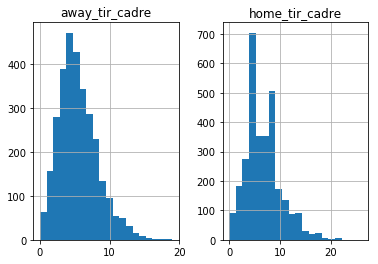

In [147]:
match[['home_tir_cadre','away_tir_cadre']].hist(bins=20)

Passons à une autre correction : on va déterminer les tirs qui ont donné l'avantage. En effet, ce sont ceux qui ont "le plus de valeur". Lorsque les deux équipes sont à égalités, elles jouent du mieux possible pour prendre l'avantage et remporter le match. A l'inverse, une équipe menée 4-0 aura tendance en fin de match à se décourager et par conséquent se prendre encore plus de buts ! 

Le calcul est un peu long, mais l'idée est de récupérer l'ordre dans lequel les buts sont arrivés, puis de compter combien de fois chacune des équipes à marqué alors qu'il y avait égalité.

In [5]:
def compte_pencher_match(equipes):  
    # Si il y a eu une erreure, on renvoie []
    if(len(np.unique(equipes)) == 0):
        return []
    
    # Si seulement 1 équipe à marqué, on renvoie 1 pour cette équipe et 0 pour l'autre (convention -1)
    if(len(np.unique(equipes)) == 1):
        [equipe1] = np.unique(equipes)
        return(np.array([[equipe1,1],[-1,0]]))
   
    # sinon
    else:
        equipe1, equipe2 = np.unique(equipes)
        
        # variable qui suit le nombre de buts marqués par chaque équipe
        count_equipe1 = 0
        count_equipe2 = 0

        # nombre de fois que chaque équipe a pris l'avantage
        penche_equipe1 = 0
        penche_equipe2 = 0

        for equipe in equipes:
            # Si équipe 1 marque
            if(equipe == equipe1):
                # Si il y avait égalité, on rajoute un point de 'prise avantage'
                if(count_equipe1 == count_equipe2):
                    penche_equipe1 = penche_equipe1 + 1
                # Et on compte le but
                count_equipe1 = count_equipe1 + 1
                
            # A l'inverse si equipe 2 marque, on fait le même test
            else:
                if(count_equipe1 == count_equipe2):
                    penche_equipe2 = penche_equipe2 + 1
                count_equipe2 = count_equipe2 + 1
            

        return(np.array([[equipe1,penche_equipe1],[equipe2,penche_equipe2]]))


# cette fonction extrait le nombre de fois où une équipe (home et away) a fait pencher le match en sa faveur
def ajuste_goals(cell):
    # on garde uniquement les lignes où il y a eu des buts (sinon pas d'effet supplémentaire)
    if(cell.startswith('<goal>')):
        tree = html.fromstring(cell)
        equipe = tree.xpath('//team/text()')
        return compte_pencher_match(np.array(equipe, dtype=np.int32))
    return []

match['avantage'] = match.goal.apply(lambda cell: ajuste_goals(cell))

def get_home_away(row, home=True):
    if(row.avantage == []):
        return 0
    else:
        (equipe1, score1), (equipe2, score2) = row.avantage
        if home:
            if equipe1 == row.home_team_api_id:
                return score1
            return score2
        else:
            if equipe1 == row.away_team_api_id:
                return score1
            return score2

match['home_avantage'] = match.apply(lambda row: get_home_away(row), axis=1)
match['away_avantage'] = match.apply(lambda row: get_home_away(row, home=False), axis=1)

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:54: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000328D5080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000044CF3668>]], dtype=object)

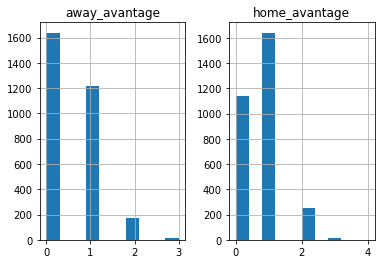

In [149]:
match[['home_avantage','away_avantage']].hist()

On va maintenant comptabiliser le nombre de corner

In [6]:
def extract_nb_corner(cell):
    tree = html.fromstring(cell)
    equipe = tree.xpath('//team/text()')
    return np.array(equipe, dtype=np.int32)

match['nb_corner'] = match.corner.apply(lambda cell: extract_nb_corner(cell))

In [7]:
def agrege_equipe_corner(row, home=True):
    if(len(row.nb_corner) > 0):
        if home:
            return (row.nb_corner == row.home_team_api_id).sum()
        else:
            return (row.nb_corner == row.away_team_api_id).sum()
    return 0
    
match['home_corner'] = match.apply(lambda row: agrege_equipe_corner(row), axis=1)
match['away_corner'] = match.apply(lambda row: agrege_equipe_corner(row, home=False), axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000EBF5F60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000004AF9DDA0>]], dtype=object)

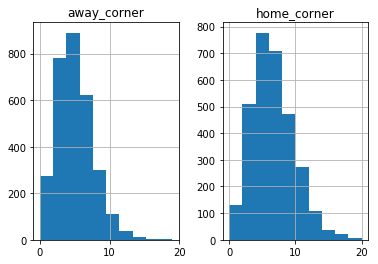

In [152]:
match[['home_corner','away_corner']].hist()

On nettoie les colonnes qui ne servent plus

In [8]:
match.drop(['id','league_id','date','goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession',
           'avantage','nb_corner','tirs_cadres'],
           axis=1, inplace=True)

match.head()

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name,recuperation_home,recuperation_away,vainqueur,home_dynamique,away_dynamique,home_score_dynamique,away_score_dynamique,home_tir_cadre,away_tir_cadre,home_avantage,away_avantage,home_corner,away_corner
53,8668,8655,2,3,Everton,Blackburn Rovers,15,15,A,NNNNN,NNNNN,0.0,0.0,2,8,1,2,3,4
55,9825,8659,1,0,Arsenal,West Bromwich Albion,15,15,H,NNNNN,NNNNN,0.0,0.0,12,2,1,0,7,5
69,8559,10194,3,1,Bolton Wanderers,Stoke City,15,15,H,NNNNN,NNNNN,0.0,0.0,5,1,1,0,4,3
73,8549,8586,2,1,Middlesbrough,Tottenham Hotspur,15,15,H,NNNNN,NNNNN,0.0,0.0,7,2,1,0,7,9
78,8472,8650,0,1,Sunderland,Liverpool,15,15,A,NNNNN,NNNNN,0.0,0.0,4,11,0,1,1,8


## Construction du modèle

Maintenant que les données sont propres et identifiées, on va construire le modèle pymc3. Pour cela, il faut changer les noms des équipes en indices allant de 1 au nombre total d'équipe

In [154]:
num_teams = len(match.away_team_api_id.unique())
teams = match.home_team_long_name.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

In [155]:
teams

,team,i
0,Everton,0
1,Arsenal,1
2,Bolton Wanderers,2
3,Middlesbrough,3
4,Sunderland,4
5,West Ham United,5
6,Hull City,6
7,Chelsea,7
8,Manchester United,8
9,Aston Villa,9


In [156]:
match = pd.merge(match, teams, left_on='home_team_long_name', right_on='team', how='left')
match = match.rename(columns = {'i': 'i_home'}).drop('team', 1)
match = pd.merge(match, teams, left_on='away_team_long_name', right_on='team', how='left')
match = match.rename(columns = {'i': 'i_away'}).drop('team', 1)

In [157]:
match.head()

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name,recuperation_home,recuperation_away,vainqueur,home_dynamique,...,home_score_dynamique,away_score_dynamique,home_tir_cadre,away_tir_cadre,home_avantage,away_avantage,home_corner,away_corner,i_home,i_away
0,8668,8655,2,3,Everton,Blackburn Rovers,15,15,A,NNNNN,...,0.0,0.0,2,8,1,2,3,4,0,10
1,9825,8659,1,0,Arsenal,West Bromwich Albion,15,15,H,NNNNN,...,0.0,0.0,12,2,1,0,7,5,1,13
2,8559,10194,3,1,Bolton Wanderers,Stoke City,15,15,H,NNNNN,...,0.0,0.0,5,1,1,0,4,3,2,16
3,8549,8586,2,1,Middlesbrough,Tottenham Hotspur,15,15,H,NNNNN,...,0.0,0.0,7,2,1,0,7,9,3,12
4,8472,8650,0,1,Sunderland,Liverpool,15,15,A,NNNNN,...,0.0,0.0,4,11,0,1,1,8,4,11


On split notre jeu de données (60/20/20) afin de pouvoir mesurer plus tard les perfomances des différents modèles testés. NB : on fait exprès de ne pas randomiser les individus qui iront en train/CV/test. En effet, les observations sont ordonnées dans le temps, et en application réelle, on a accès uniquement au passé pour prédire le futur.

In [185]:
# On compte le nombre d'observations dont on dispose
taille_totale = len(match.home_team_goal.values)
# on calcule le nombre d'observations que l'on envoie en training set
train_size = int(taille_totale*0.6)
CV_size = int(taille_totale*0.8)

# On met en forme les resultats observés
observed_home_tir_cadre = match.home_tir_cadre.values[:train_size]
observed_away_tir_cadre = match.away_tir_cadre.values[:train_size]

observed_home_avantage = match.home_avantage.values[:train_size]
observed_away_avantage = match.away_avantage.values[:train_size]

observed_home_corner = match.home_corner.values[:train_size]
observed_away_corner = match.away_corner.values[:train_size]

observed_home_goal = match.home_team_goal.values[:train_size]
observed_away_goal = match.home_team_goal.values[:train_size]

# Et les inputs
home_team = match.i_home.values[:train_size]
away_team = match.i_away.values[:train_size]

home_recuperation = np.array(match.recuperation_home.values[:train_size], dtype=np.float64)
away_recuperation = np.array(match.recuperation_away.values[:train_size], dtype=np.float64)

home_dynamique = np.array(match.home_score_dynamique.values[:train_size], dtype=np.float64)
away_dynamique = np.array(match.away_score_dynamique.values[:train_size], dtype=np.float64)

In [186]:
import theano
import numpy as np

vecteur_1 = np.ones(shape=len(home_team))
vecteur_0 = np.zeros(shape=len(home_team))

model_input_team = theano.shared(np.array([home_team, away_team]))
model_input_home = theano.shared(np.array([home_recuperation , home_dynamique]))
model_input_away = theano.shared(np.array([away_recuperation , away_dynamique]))

model_output = theano.shared(np.array([observed_home_goal, observed_away_goal,
                                       observed_home_tir_cadre, observed_away_tir_cadre,
                                      observed_home_avantage, observed_away_avantage,
                                      observed_home_corner, observed_away_corner])
                            )

Puis on écrit le modèle

In [188]:
import pymc3 as pm

model = pm.Model()
with pm.Model() as model:
    but_home_observe = model_output[0] #1 * model_output[0] + 1.2 * model_output[2] + 0.8 * model_output[4] #pm.math.dot(pi1, model_output[::2])
    but_away_observe = model_output[1] #1 * model_output[1] + 1.2 * model_output[3] + 0.8 * model_output[5] #pm.math.dot(pi1, model_output[1::2])
    
    # shape parameter des lois de student
    hyper_lambda = pm.Uniform('hyper_lambda', lower=0, upper=30, shape=1)
    
    # Paramètres spécifiques à chaque équipe  
    attaque = pm.StudentT("attaque", nu=2, mu=0, lam=hyper_lambda, shape=num_teams)
    defense = pm.StudentT("defense", nu=2, mu=0, lam=hyper_lambda, shape=num_teams)
    
    # Paramètre lié aux conditions du match
    coeffs = pm.StudentT("coeffs", nu=2, mu=0, lam=hyper_lambda, shape=5)
    
    # On met en forme l'entrée du modèle linéaire
    vecteur_input_home = theano.tensor.stack([
        theano.tensor.ones_like(model_input_home[0]), 
        theano.tensor.ones_like(model_input_home[0]), 
        model_input_home[0] - model_input_away[0],
        model_input_home[1] - model_input_away[1],
        attaque[model_input_team[0]] - defense[model_input_team[1]]
    ])
    
    vecteur_input_away = theano.tensor.stack([
        theano.tensor.ones_like(model_input_home[0]), 
        theano.tensor.zeros_like(model_input_home[0]), 
        model_input_away[0] - model_input_home[0],
        model_input_away[1] - model_input_home[1],
        attaque[model_input_team[1]] - defense[model_input_team[0]]
    ])
    
    # Modèle linéaire à proprement parler
    home_theta = pm.math.dot(coeffs, vecteur_input_home)
    away_theta = pm.math.dot(coeffs, vecteur_input_away)
    

    # likelihood of observed data 
    home_points = pm.Poisson('home_points', mu=pm.math.exp(home_theta), observed=but_home_observe)
    away_points = pm.Poisson('away_points', mu=pm.math.exp(away_theta), observed=but_away_observe)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...

Average ELBO = -5,853.5: 100%|██████████████████████████████████████████████████| 30000/30000 [01:21<00:00, 368.64it/s]Finished [100%]: Average ELBO = -5,845.9
INFO (theano.gof.compilelock): Refreshing lock C:\Users\Alexis\AppData\Local\Theano\compiledir_Windows-10-10.0.14393-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.13-64\lock_dir\lock

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [04:28<00:00,  1.86it/s]

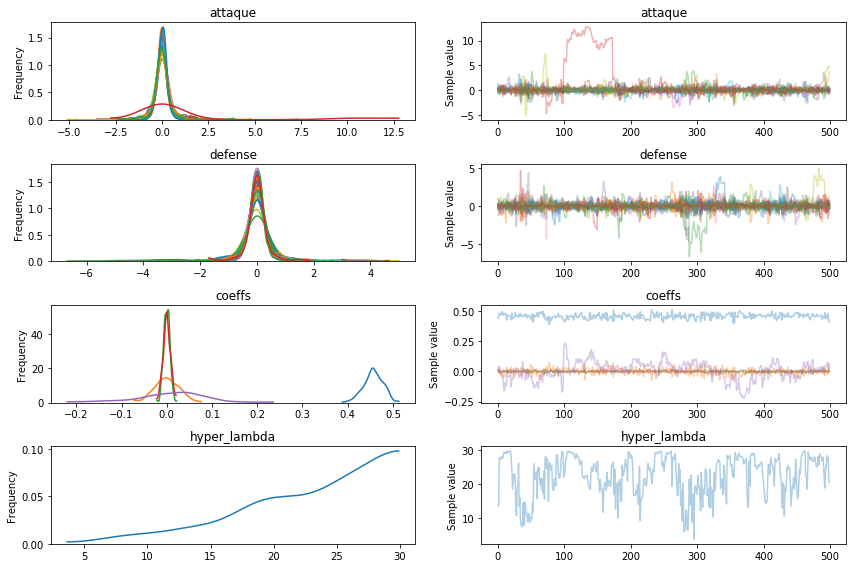

In [175]:
with model:
    #start = pm.find_MAP()
    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start)
    #trace = pm.sample(1000, step, start=start, progressbar=True)
    trace = pm.sample(500, n_init=30000)

    pm.traceplot(trace)

La phase de sampling étant terminé, on va afficher pour chaque équipe la ditribution à posteriori des paramètres d'attaque et de défense sous forme de forestplot : 

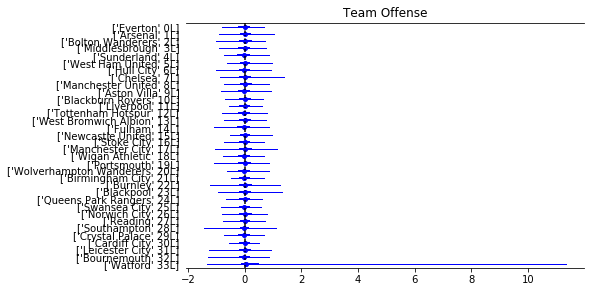

In [176]:
pm.forestplot(trace[10:], varnames=['attaque'], ylabels=teams.values, main="Team Offense", chain_spacing=0.2)

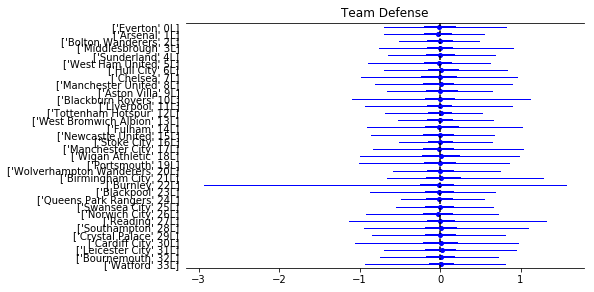

In [177]:
pm.forestplot(trace[10:], varnames=['defense'], ylabels=teams.values, main="Team Defense", chain_spacing=0.2)

Les résultats sont toujours cohérent. Etant donné que c'est le dernier modèle que nous explorerons, on va l'enregistrer afin de pouvoir s'en resservir plus tard dans le 'vrai' programme final :

In [ ]:
with model:
    db = pm.backends.text.Text(name='Trace')
    trace = pm.sample(500, n_init=50000, trace=db)

# Evaluation des perfomances du modèle

Maintenant que l'on a vu que notre modèle est fonctionnel (et cohérent !), nous allons dans cette dernière section évaluer notre modèle. On commence par récupérer les données de cross-validation :

In [ ]:
"""On définit les nouvelles entrées et sorties"""
#sortie
observed_home_goals = match.home_team_goal.values[train_size+1:CV_size]
observed_away_goals = match.away_team_goal.values[train_size+1:CV_size]

observed_home_tir_cadre = match.home_tir_cadre.values[:train_size]
observed_away_tir_cadre = match.away_tir_cadre.values[:train_size]

observed_home_avantage = match.home_avantage.values[:train_size]
observed_away_avantage = match.away_avantage.values[:train_size]

observed_home_corner = match.home_corner.values[:train_size]
observed_away_corner = match.away_corner.values[:train_size]

#entree
home_team = match.i_home.values[train_size+1:CV_size]
away_team = match.i_away.values[train_size+1:CV_size]

home_recuperation = np.array(match.recuperation_home.values[train_size+1:CV_size], dtype=np.float64)
away_recuperation = np.array(match.recuperation_away.values[train_size+1:CV_size], dtype=np.float64)

home_dynamique = np.array(match.home_score_dynamique.values[train_size+1:CV_size], dtype=np.float64)
away_dynamique = np.array(match.away_score_dynamique.values[train_size+1:CV_size], dtype=np.float64)

"""On les rentre dans les shared value theano"""
model_input_team = theano.shared(np.array([home_team, away_team]))
model_input_home = theano.shared(np.array([home_recuperation, home_dynamique]))
model_input_away = theano.shared(np.array([away_recuperation, away_dynamique]))


"""Et on sample"""
ppc = pm.sample_ppc(trace[10:], model=model, samples=100)

L'échantillon est désormais créé, on va maintenant comparer nos prédictions avec la réalité :

In [179]:
"""On rassemble dans des dataframe"""
away_prediction = pd.DataFrame(ppc['away_points'])
home_prediction = pd.DataFrame(ppc['home_points'])  

prediction_score = [home_prediction[[i]].merge(away_prediction[[i]], 
                                               how='inner', 
                                               left_index=True, right_index=True) 
                    for i in range(len(home_team))]

for df in prediction_score:
    df.columns = ['home_prediction', 'away_prediction']
    
"""Pour chaque dataframe, on détermine l'équipe qui gagne"""
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'
    
for df in prediction_score:
    df['prediction_vainqueur'] = df.apply(vainqueur, axis=1) 
    
"""Et on ajoute le score le plus probable"""
resultats = list()
    
for df in prediction_score:
    home_score, away_score = df.groupby(["home_prediction", "away_prediction"]).size().idxmax()
    resultats.append(
        [df.prediction_vainqueur.value_counts().idxmax(), home_score, away_score]
    )
    
resultats = pd.DataFrame(np.array(resultats))
resultats.columns = ['prediction_vainqueur', 'prediction_home_score', 'prediction_away_score']

#on remet les scores au type int, sinon il sont converti en 'objet' ...
resultats[['prediction_home_score', 'prediction_away_score']] = resultats[['prediction_home_score', 'prediction_away_score']].astype(np.int32)

"""Enfin on met en forme les vrais résultats pour pouvoir comparer"""
vrai_home = pd.DataFrame(observed_home_goals)
vrai_away = pd.DataFrame(observed_away_goals) 

vrai_resultats = vrai_home.merge(vrai_away, how='inner', left_index=True, right_index=True)
vrai_resultats.columns = ['home_points', 'away_points']

vrai_resultats['vainqueur'] = vrai_resultats.apply(vainqueur, axis=1)

vrai_resultats = vrai_resultats.merge(resultats, how='inner', left_index=True, right_index=True)

In [180]:
vrai_resultats

,home_points,away_points,vainqueur,prediction_vainqueur,prediction_home_score,prediction_away_score
0,3,2,H,A,1,1
1,1,3,A,H,1,1
2,2,2,N,A,1,1
3,0,2,A,H,1,1
4,1,2,A,H,1,1
5,2,1,H,A,2,1
6,1,1,N,H,1,1
7,1,0,H,A,1,1
8,0,0,N,A,1,2
9,2,2,N,A,2,2


On calcule notre score :

In [181]:
from sklearn import metrics

metrics.accuracy_score(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)

0.37397034596375617

Ce n'est pas si mal pour un premier modèle, extrèmement simple pour le moment... Cherchons à identifier quels matchs sont mal classifiés :

In [182]:
vrai_resultats.vainqueur.count()

607

In [183]:
vrai_resultats.vainqueur.value_counts() / vrai_resultats.vainqueur.count()

H    0.444811
A    0.314662
N    0.240527
Name: vainqueur, dtype: float64

prochaine étapes :
- améliorer le modèle hierarchique (prendre en compte les tirs cadrés, etc.)
- modéliser au niveau de chaque joueur ?
- écrire le code d'une simulation d'une saison entière pour obtenir le classement final

Enfin, on va compter le nombre de fois où notre projection de score est correcte

In [170]:
score_juste = vrai_resultats[vrai_resultats.home_points == vrai_resultats.prediction_home_score]
score_juste = score_juste[vrai_resultats.away_points == vrai_resultats.prediction_away_score]
len(score_juste) / float(len(vrai_resultats))

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


0.0

On a prédit le bon score dans 14.5% des cas.

Par la suite, on améliorera le modèle selon 3 axes :
- les buts étant des évênements rares, ils sont soumis à une grande variabilité et peuvent donc être une métrique trompeuse. Il va donc falloir "l'augmenter" avec d'autres évênements moins rares, mais quasiment tout autant important : le nombre de tirs cadrés, non cadrés, corner, de pénaltis, etc.
- mieux charactériser les paramètres latents d'une équipe. On a ici résumé l'information disponible à un score d'attaque et un score de défense, mais il y en a certainement d'autres : la possession moyenne de balle par exemple ? ...
- mieux charactériser la situation du match, indépendement des performances d'une équipe : le fait de jouer à domicile a été pris en compte ici, mais on peut penser à d'autres choses, tels que le temps de repos depuis le dernier match, etc.
- prendre en compte l'évolution du style de jeu au cours des années (cf le notebook sur les buts vs loi de poisson)

Eventuellement plus tard modéliser au niveau du joueur

Pour fnir, on sauvegarde la trace, on en aura besoin dans le vrai programme

# Quelques analyses en plus 

In [12]:
def extract_time_elapsed(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        coord = tree.xpath('//elapsed/text()')
        return np.array(coord, dtype=np.int32)
    return np.nan

match['time_elapsed'] = match.goal.apply(lambda row: extract_time_elapsed(row))

Regardons la distribution des buts par minute d'un match

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001F7A6978>]], dtype=object)

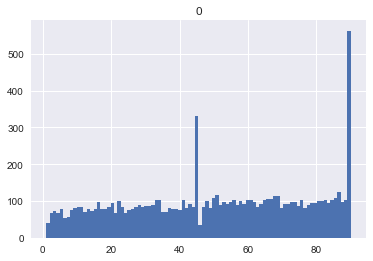

In [19]:
pd.DataFrame(np.hstack(match.time_elapsed.values)).hist(bins=90)

On observe beaucoup plus de buts à la 45ème et à la 90ème minutes ! En effet, les buts marqués pendants le temps additionel (91, 92, 93ème minutes) sont compté comme 90. Idem pour 45.

Etudions la position (distance + angle en degré) des tirs :

In [14]:
def extract_position_distance(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        coord = tree.xpath('//coordinates/value/text()')
        return np.array(coord[0:][::2], dtype=np.int32)
    return np.nan

def extract_position_angle(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        coord = tree.xpath('//coordinates/value/text()')
        return np.array(coord[1:][::2], dtype=np.int32)
    return np.nan

match['position_distance'] = match.goal.apply(lambda row: extract_position_distance(row))
match['position_angle'] = match.goal.apply(lambda row: extract_position_angle(row))

In [15]:
heatmap = pd.DataFrame([np.hstack(match.position_distance.values),np.hstack(match.position_angle.values)]).T
heatmap.dropna(inplace=True)
heatmap.columns = ['Distance', 'Angle']

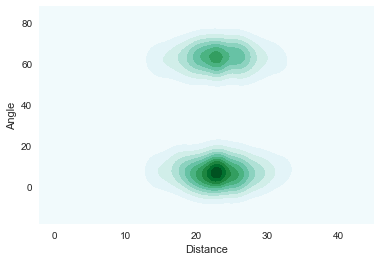

In [20]:
import seaborn
seaborn.kdeplot(heatmap.Distance, heatmap.Angle, shade=True)

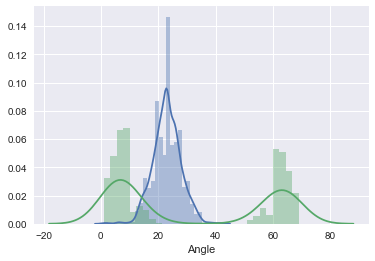

In [21]:
seaborn.distplot(heatmap.Distance, bins=30)
seaborn.distplot(heatmap.Angle, bins=30)